In [28]:
import os
import numpy as np
import glob
from collections import defaultdict
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw


In [29]:
def dataconcat (dir_path): # path of the folder containing the netCDF files 
    all_files = glob.glob(os.path.join(dir_path, "*.nc")) 
    
    groups = defaultdict(list) 
    for fp in all_files: 
        fname = os.path.basename(fp) 
        model_name = fname.split("_")[2] 
        groups[model_name].append(fp) 
        datasets = {}

    for prefix, files in groups.items(): 
        files = sorted(files) 
        print(f"Concatenating {len(files)} files for {prefix}") 
        ds = xr.open_mfdataset( files, combine="by_coords", parallel=True ) 
        datasets[prefix] = ds.isel(time=slice(-20 * 12, None)) 
    
    return datasets 
              
sst_datasets = dataconcat("/glade/work/stevenxu/AMOC_models/sea_surface_temperature/scenarios/PIControl") 
sss_datasets = dataconcat("/glade/work/stevenxu/AMOC_models/sea_surface_salinity/scenarios/PIControl") 
hf_datasets = dataconcat("/glade/work/stevenxu/AMOC_models/heatflux/scenarios/PIControl") 
wf_datasets = dataconcat("/glade/work/stevenxu/AMOC_models/waterflux/scenarios/PIControl")

Concatenating 1 files for ACCESS-CM2
Concatenating 1 files for ACCESS-CM2
Concatenating 1 files for ACCESS-CM2
Concatenating 1 files for ACCESS-CM2


In [30]:
sss_datasets["ACCESS-CM2"]

<xarray.Dataset> Size: 112MB
Dimensions:             (time: 240, bnds: 2, j: 300, i: 360, vertices: 4)
Coordinates:
  * time                (time) object 2kB 1430-01-16 12:00:00 ... 1449-12-16 ...
  * j                   (j) int32 1kB 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
  * i                   (i) int32 1kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    latitude            (j, i) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    longitude           (j, i) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object 4kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 3MB dask.array<chunksize=(300, 360, 2), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 3MB dask.array<chunksize=(300, 360, 2), meta=np.ndarray>
    sos                 (time, j, i) float32 104MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  346615.0
    creation_date:          2019-11-12T14:58:27Z
    ...                     ...
    variable_id:            sos
    variant_label:          r1i1p1f1
    version:                v20191112
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/924fd545-0ce6-4fc1-a21e-3c152368dce0
    license:                CMIP6 model data produced by CSIRO is licensed un...

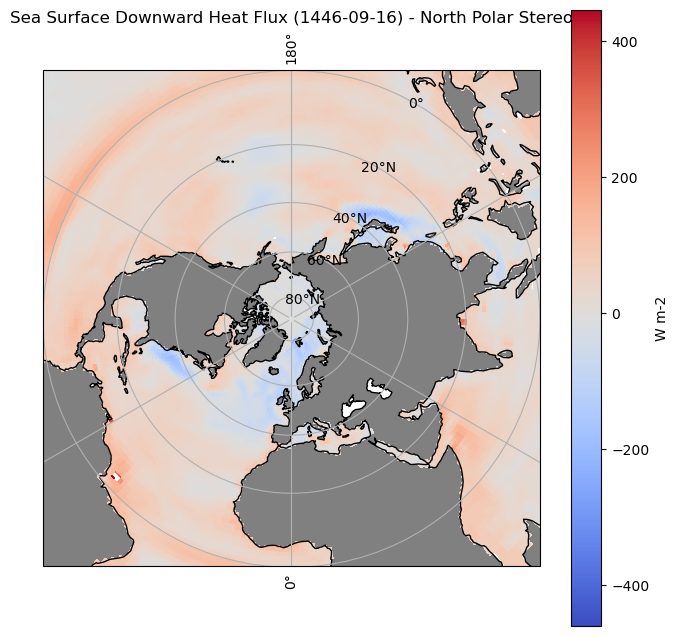

In [31]:
ds = hf_datasets["ACCESS-CM2"]
da = ds['hfds'].isel(time=200)
da = da.where(da < 480)

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
ax.add_feature(cfeature.LAND, facecolor='gray', zorder=0)

ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
pcm = ax.pcolormesh(
    ds['longitude'], ds['latitude'], da,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm'
)
plt.colorbar(pcm, ax=ax, orientation='vertical', label=da.units)
plt.title(f"Sea Surface Downward Heat Flux ({str(ds['time'].values[200])[:10]}) - North Polar Stereo")
plt.show()

# Calculate sea surface density

In [32]:
def compute_surface_density(model, sst_datasets, sss_datasets, last_n_months=None):
    T  = sst_datasets[model]['tos']          
    SP = sss_datasets[model]['sos']          
    lon = sst_datasets[model]['longitude']
    lat = sst_datasets[model]['latitude']
    p0 = 0.0

    if last_n_months is not None:
        T  = T.isel(time=slice(-last_n_months, None))
        SP = SP.isel(time=slice(-last_n_months, None))

    SA = xr.apply_ufunc(
        gsw.SA_from_SP, SP, p0, lon, lat,
        dask='parallelized', vectorize=True, output_dtypes=[float]
    )
    CT = xr.apply_ufunc(
        gsw.CT_from_t, SA, T, p0,
        dask='parallelized', vectorize=True, output_dtypes=[float]
    )
    alpha = xr.apply_ufunc(
        gsw.density.alpha, SA, CT, p0,
        dask='parallelized', output_dtypes=[float]
    )
    beta = xr.apply_ufunc(
        gsw.density.beta, SA, CT, p0,
        dask='parallelized', output_dtypes=[float]
    )
    rho = xr.apply_ufunc(
        gsw.density.rho, SA, CT, p0,
        dask='parallelized', vectorize=True, output_dtypes=[float]
    )

    rho  = rho.rename('rho').assign_attrs(units='kg m-3',  long_name='Sea-surface density')
    alpha  = alpha.rename('alpha')
    beta  = beta.rename('beta')



    return xr.Dataset(dict(rho=rho, alpha=alpha, beta=beta))

surf_den_ACCESS = compute_surface_density("ACCESS-CM2", sst_datasets, sss_datasets, last_n_months=240)
surf_den_ACCESS

<xarray.Dataset> Size: 624MB
Dimensions:    (time: 240, j: 300, i: 360)
Coordinates:
  * time       (time) object 2kB 1430-01-16 12:00:00 ... 1449-12-16 12:00:00
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
Data variables:
    rho        (time, j, i) float64 207MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    alpha      (time, j, i) float64 207MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    beta       (time, j, i) float64 207MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>

# Plotting Sea Surface Density

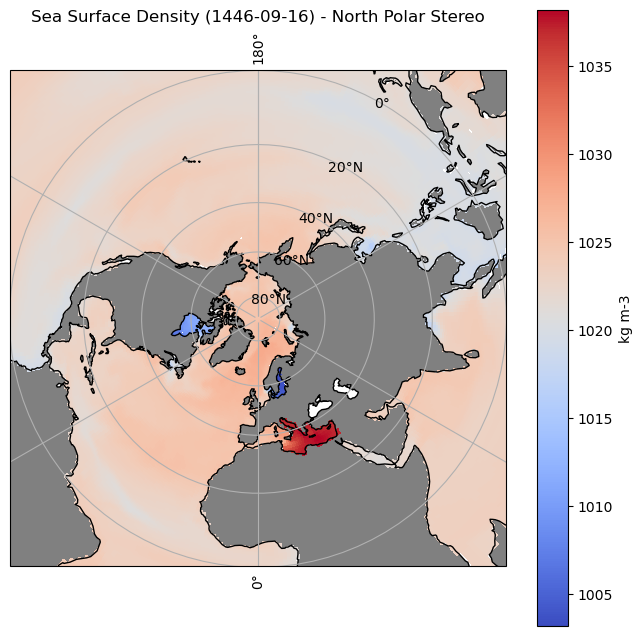

In [33]:
ds = surf_den_ACCESS
da = ds['rho'].isel(time=200)
#da = da.where(da < 480)

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
ax.add_feature(cfeature.LAND, facecolor='gray', zorder=0)

ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
pcm = ax.pcolormesh(
    ds['longitude'], ds['latitude'], da,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm'
)
plt.colorbar(pcm, ax=ax, orientation='vertical', label=da.units)
plt.title(f"Sea Surface Density ({str(ds['time'].values[200])[:10]}) - North Polar Stereo")
plt.show()

# Calculate F surf

In [36]:
def compute_fsurf(model,
                  sst_datasets, sss_datasets, hf_datasets, wf_datasets,
                  cp=3990.0, rho0=1027.0, rho_fw=1000.0, S0=35.0,
                  last_n_months=None):

    HF = hf_datasets[model]['hfds']  # W m^-2, 
    WF = wf_datasets[model]['wfo']     # kg m^-2 s^-1, 
    lon = sst_datasets[model]['longitude']
    lat = sst_datasets[model]['latitude']
    p0 = 0.0

    density_data = compute_surface_density(model, sst_datasets, sss_datasets, last_n_months=last_n_months)
    rho = density_data['rho']
    alpha = density_data['alpha']
    beta = density_data['beta']

    if last_n_months is not None:
        HF  = HF.isel(time=slice(-last_n_months, None))
        WF = WF.isel(time=slice(-last_n_months, None))

    # f_surf = -(alpha/cp) * f_heat  - (rho0/rho_fw) * beta * S0 * f_water
    fsurf = -(alpha / cp) * HF  -  (rho0 / rho_fw) * beta * S0 * WF
    fsurf = fsurf.assign_attrs(
        long_name="Buoyancy-relevant surface forcing (Eq. 5)",
        description="-(alpha/cp)*f_heat - (rho0/rho_fw)*beta*S0*f_water",
        units="",
        cp=cp, rho0=rho0, rho_fw=rho_fw, S0=S0
    )

    return xr.Dataset(dict(fsurf=fsurf, rho=rho))

out_ACCESS = compute_fsurf(
    "ACCESS-CM2",
    sst_datasets=sst_datasets,
    sss_datasets=sss_datasets,
    hf_datasets=hf_datasets,
    wf_datasets=wf_datasets,
    last_n_months=240
)

out_ACCESS

<xarray.Dataset> Size: 416MB
Dimensions:    (time: 240, j: 300, i: 360)
Coordinates:
  * time       (time) object 2kB 1430-01-16 12:00:00 ... 1449-12-16 12:00:00
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
Data variables:
    fsurf      (time, j, i) float64 207MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    rho        (time, j, i) float64 207MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>

# Plotting F surf

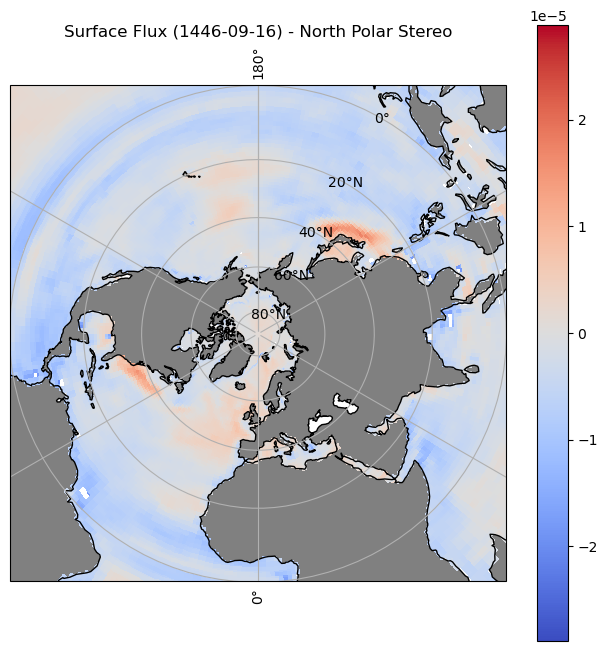

In [37]:
ds = out_ACCESS
da = ds['fsurf'].isel(time=200)
da = da.where(da > -0.00002)  # filter out the abnormal values

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
ax.add_feature(cfeature.LAND, facecolor='gray', zorder=0)

ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())

v = np.nanmax(np.abs(da.values))
pcm = ax.pcolormesh(
    ds['longitude'], ds['latitude'], da,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    vmin=-v, vmax=v
)
plt.colorbar(pcm, ax=ax, orientation='vertical', label=da.units)
plt.title(f"Surface Flux ({str(ds['time'].values[200])[:10]}) - North Polar Stereo")
plt.show()